In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Библиотеки\Libraries

In [2]:
# для работы с графиками
# for working with charts

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# модели
# models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# метрики
# metrics
from sklearn.metrics import (roc_auc_score,
                             accuracy_score,
                             roc_curve, 
                             confusion_matrix)


from sklearn.model_selection import( train_test_split,
                                    GridSearchCV, RandomizedSearchCV,
                                    StratifiedKFold)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder, 
                                   StandardScaler)
from sklearn.impute import SimpleImputer


from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)

In [3]:
# создание констант для моделей
import random
RANDOM_STATE = 25052015

TEST_SIZE = 0.25
random.seed(RANDOM_STATE)

## Шаг 1. Загрузка данных\Step 1. Loading data

In [4]:
def load_data(paths):
    """
    Читает CSV-файл по указанному пути.

    paths: Список путей к файлам.
    return: DataFrame, если файл найден и прочитан, иначе None.
    """
    for path in paths:
        if os.path.exists(path):
            try:
                return pd.read_csv(path)
                print(f"Файл загружен из пути' {path}': {e}")
            
            except Exception as e:
                print(f"Ошибка при чтении файла '{path}': {e}")
                continue
    print("Файл не найден ни по одному из путей.")
    return None

In [5]:
# Загрузка датафрейма contract_new
paths = [
    '/kaggle/input/titanic/train.csv'
]

titanic_train = load_data(paths)

In [6]:
# Загрузка датафрейма contract_new
paths = [
    '/kaggle/input/titanic/test.csv'
]

titanic_test = load_data(paths)

In [7]:
titanic_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
id_pred = titanic_test['PassengerId']
id_pred

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

## Шаг 2. Исследовательский анализ и предобработка данных. \Step 2. Exploratory data analysis and preprocessing
исследовательский анализ каждого датафрейма. при необходимости выполняется предобработка. выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

exploratory analysis of each dataframe. preprocessing is performed if necessary. conclusions about the available features: whether they will be needed for training models.

In [9]:
def get_data_info(data):
    display(data.sample(5))
    print('-'*40)
    print('Numeric data describe')
    display(data.describe())
    print('-'*40)
    print('Object data describe')
    display(data.describe(include='O'))
    print('-'*40)
    print('Пропуски:', data.isna().sum())
    print('-'*40)
    data.info()

In [10]:
get_data_info(titanic_train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
805,806,0,3,"Johansson, Mr. Karl Johan",male,31.0,0,0,347063,7.7750,NaN,S
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
147,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.3750,NaN,S
79,80,1,3,"Dowdell, Miss. Elizabeth",female,30.0,0,0,364516,12.4750,NaN,S
177,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C


----------------------------------------
Numeric data describe


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


----------------------------------------
Object data describe


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


----------------------------------------
Пропуски: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked   

In [11]:
get_data_info(titanic_test)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
271,1163,3,"Fox, Mr. Patrick",male,NaN,0,0,368573,7.7500,NaN,Q
100,992,1,"Stengel, Mrs. Charles Emil Henry (Annie May Morris)",female,43.0,1,0,11778,55.4417,C116,C
272,1164,1,"Clark, Mrs. Walter Miller (Virginia McDowell)",female,26.0,1,0,13508,136.7792,C89,C
322,1214,2,"Nesson, Mr. Israel",male,26.0,0,0,244368,13.0000,F2,S
157,1049,3,"Lundin, Miss. Olga Elida",female,23.0,0,0,347469,7.8542,NaN,S


----------------------------------------
Numeric data describe


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


----------------------------------------
Object data describe


,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


----------------------------------------
Пропуски: PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), objec

In [12]:
titanic_train.groupby(['Ticket'], as_index=False)['Name'].count().sort_values(by='Name', ascending=True)


,Ticket,Name
340,347464,1
380,349241,1
379,349240,1
378,349239,1
598,PC 17601,1
...,...,...
566,CA 2144,6
337,347088,6
333,347082,7
80,1601,7


In [13]:
titanic_train.loc[titanic_train['Ticket'] == 'CA. 2343']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Номер билета включает в том числе буквенные значения, поэтому признак имеет тип object. По 1 билету могли путешествовать всей семьей

### Пропуски


In [14]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
            .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

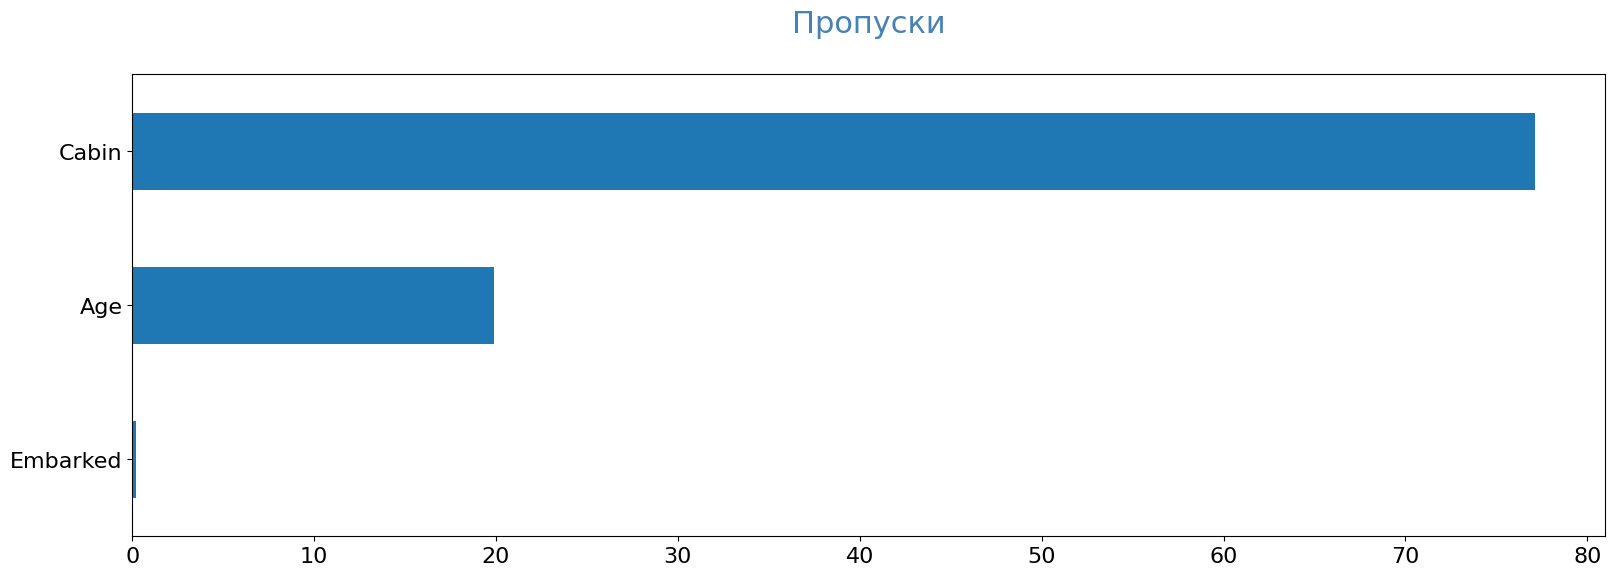

In [15]:
pass_value_barh(titanic_train)

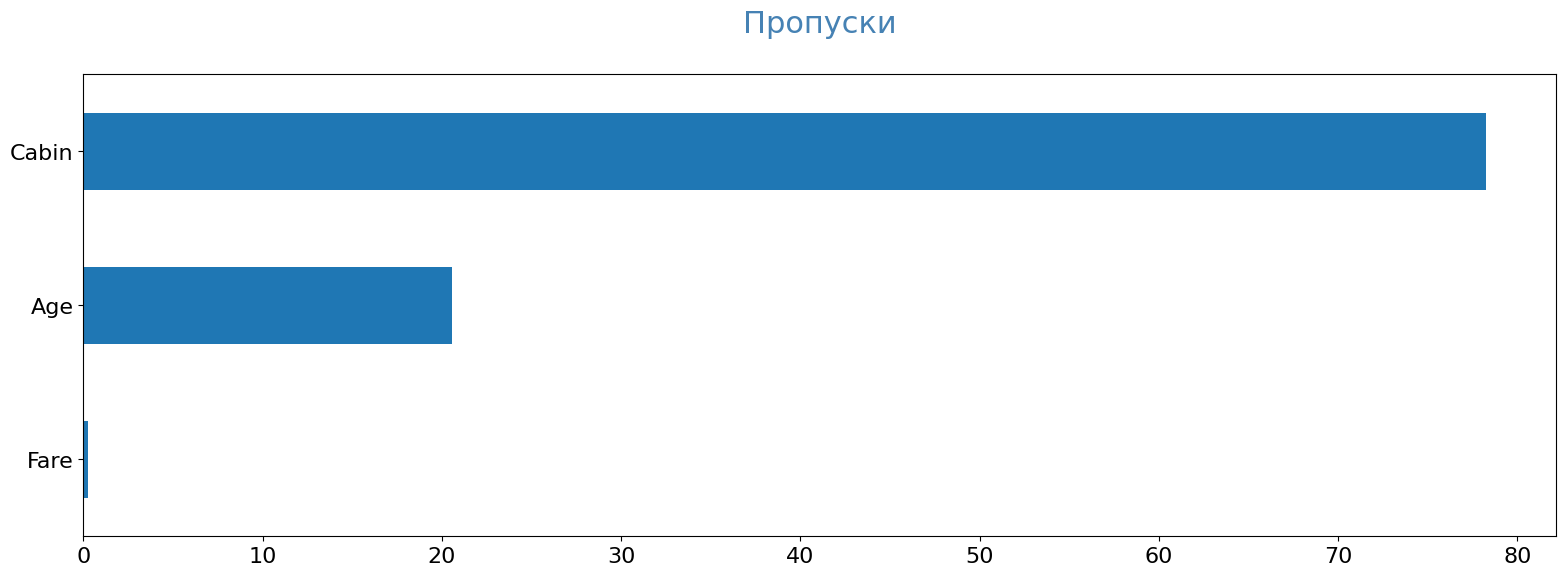

In [16]:
pass_value_barh(titanic_test)

#### Вывод\Conclusion
Как мы можем видеть есть пропуски данных в признаках Age и Cabin. Признак Cabin имеет слишком много пропусков, его придется удалить. В представленных датасетах приблизительно одинаковое количечтво пропусков в признаках Cabin и Age. Пропуски в признаке Embarked заполним модой, в Fare заполним медианой.

As we can see, there are data gaps in the Age and Cabin attributes. The Cabin attribute has too many gaps and will have to be removed. In the presented datasets, there are approximately the same number of gaps in the Cabin and Age attributes. The gaps in the Embarked attribute will be filled with the mode, and in Fare we will be filled with the median.

#### Embarked

Пропуски: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


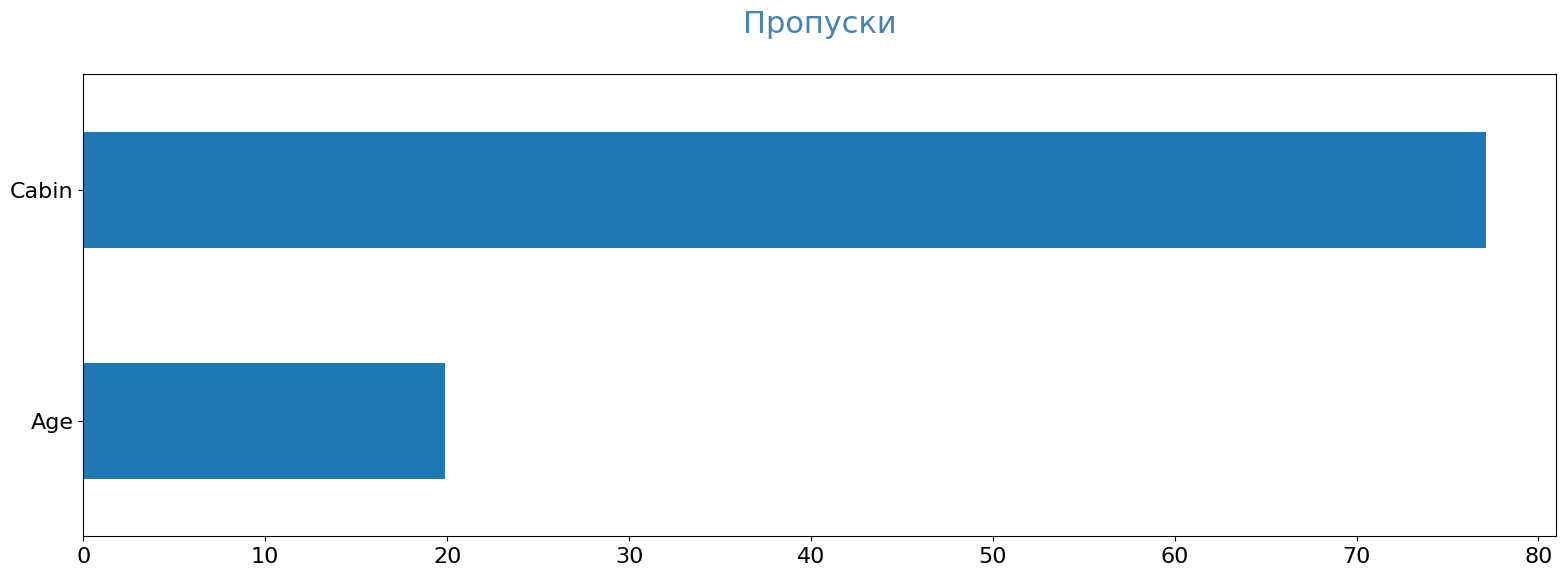

In [17]:
titanic_train.Embarked.fillna(titanic_train['Embarked'].mode()[0], inplace=True)
pass_value_barh(titanic_train)
print('Пропуски:', titanic_train.isna().sum())

Пропуски: PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


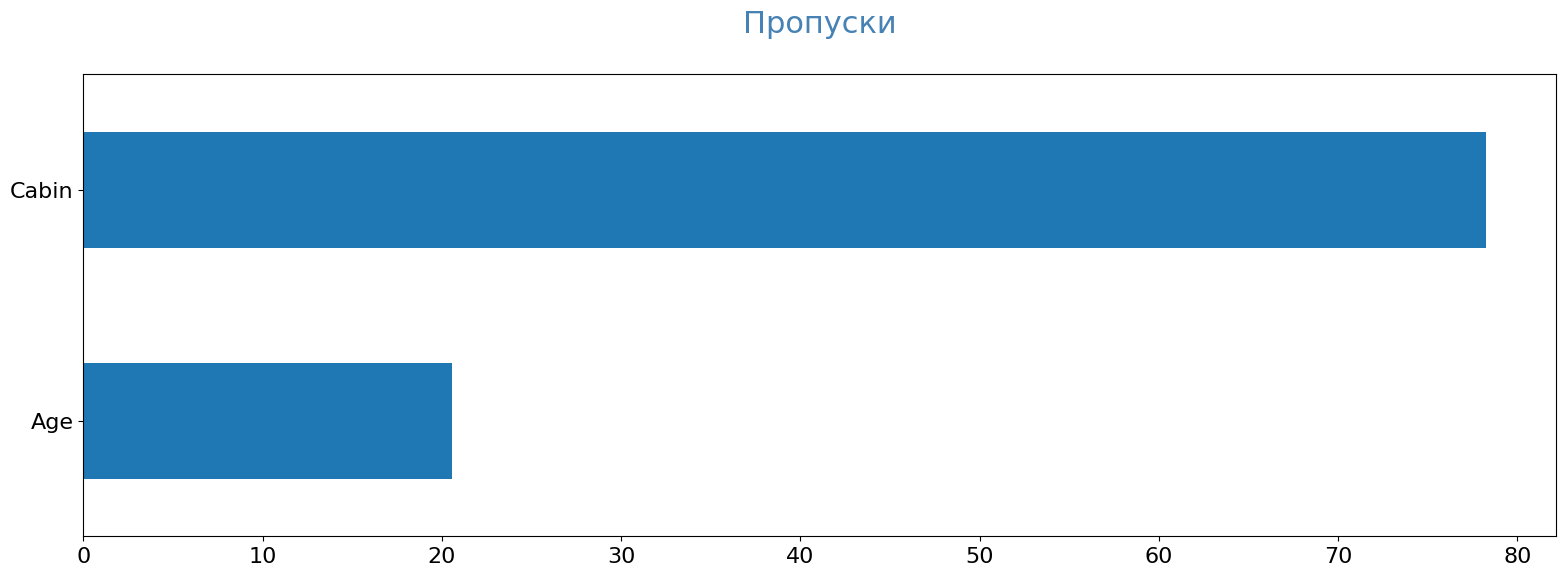

In [18]:
titanic_test.Fare.fillna(titanic_test.Fare.median(), inplace=True)
pass_value_barh(titanic_test)
print('Пропуски:', titanic_test.isna().sum())

#### Age

<Axes: >

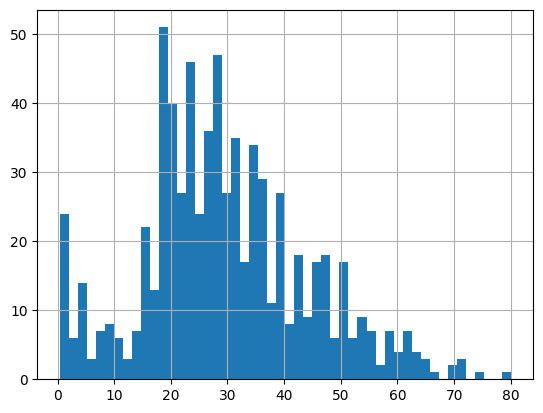

In [19]:
titanic_train.Age.hist(bins=50)

<Axes: >

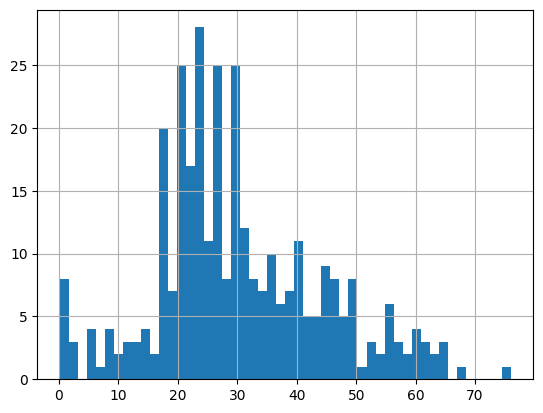

In [20]:
titanic_test.Age.hist(bins=50)

before count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
after count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64


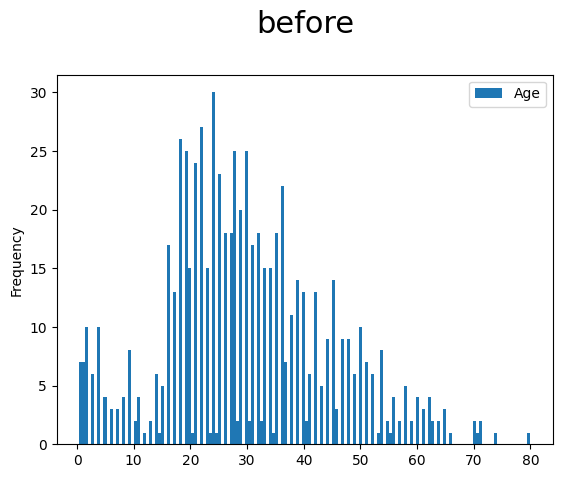

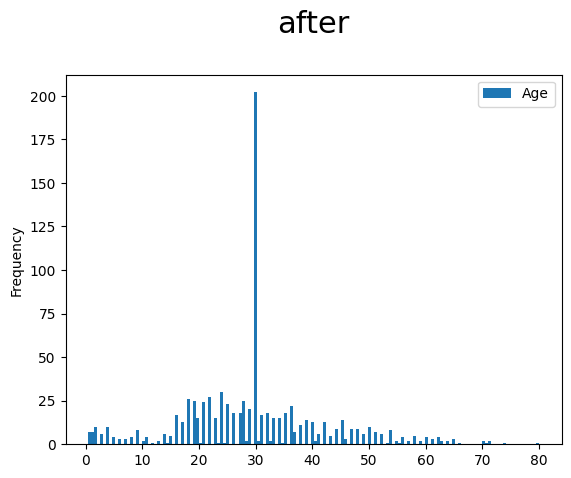

In [21]:
(titanic_train.plot(y = 'Age', kind='hist', bins = 150)
 .set_title('before' + "\n", fontsize = 22, color = 'black')
)
print ('before',titanic_train.Age.describe())
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
titanic_train['Age'] = imputer.fit_transform(titanic_train[['Age']])
titanic_test['Age'] = imputer.fit_transform(titanic_test[['Age']])
(titanic_train.plot(y = 'Age', kind='hist', bins = 150)
 .set_title('after' + "\n", fontsize = 22, color = 'black')
)
print ('after',titanic_train.Age.describe())

Гистограмма распределения пассажиров по возрасту мало информативна. Заполним пропуски с помощью KNNImputer и переведем признак в категориальный 
    
    Младенчество\Infancy (от рождения до 1 года)
    Раннее детство\Early childhood (1—3 лет)
    Игровой возраст, дошкольный\preschool (4—7 лет)
    Школьный возраст\School (7-12 лет)
    Юность\Youth (13—19 лет)
    Молодость\Young adult (19-25 лет)
    Зрелость\Mature (25-40 лет)
    Взрослость\Adult (40-60 лет)
    Старость\Old (от 60 лет) — период, когда основная работа жизни закончилась

In [22]:
#функция для преобразования номера в день недели
def age_category(number):
    
    if number<=1:
        return 'Infancy'
    if 1<number<=3:
        return 'Early childhood'
    if 3<number<=7:
        return 'Preschool'
    if 7<number<=12:
        return 'School'
    if 12<number<=19:
        return 'Youth'
    if 19<number<=25:
        return 'Young adult'
    if 25<number<=40:
        return 'Mature'
    if 40<number<=60:
        return 'Adult'
    return 'Old'
titanic_train['AgeCat'] = titanic_train['Age'].apply(age_category)
titanic_test['AgeCat'] = titanic_test['Age'].apply(age_category)


In [23]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,Mature
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Mature
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mature
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mature


#### Fare

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

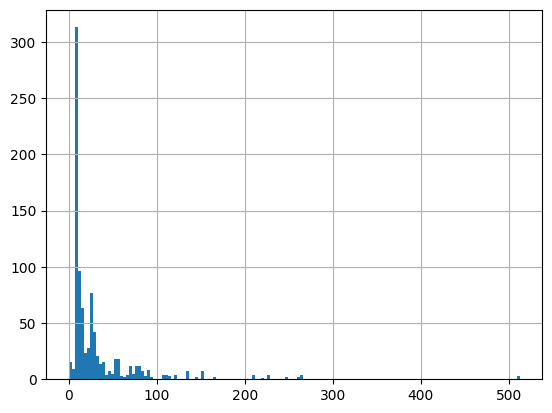

In [24]:
titanic_train.Fare.hist(bins=150)
titanic_train.Fare.describe()

count    418.000000
mean      35.576535
std       55.850103
min        0.000000
25%        7.895800
50%       14.454200
75%       31.471875
max      512.329200
Name: Fare, dtype: float64

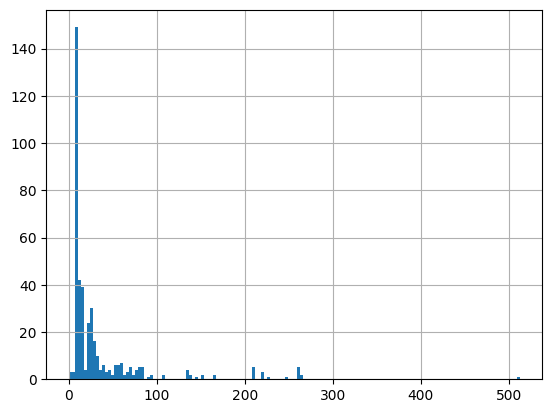

In [25]:
titanic_test.Fare.hist(bins=150)
titanic_test.Fare.describe()

In [26]:
titanic_train.Fare.isna().sum()

0

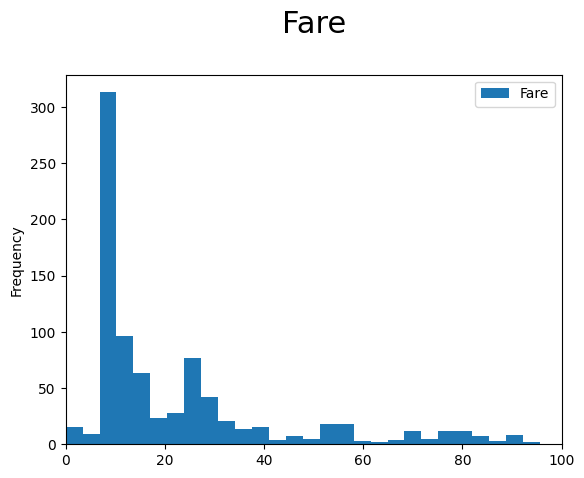

In [27]:
(titanic_train.plot(y = 'Fare', kind='hist', bins = 150)
 .set_title('Fare' + "\n", fontsize = 22, color = 'black')
)
plt.xlim(0, 100);

In [28]:
titanic_train.loc[titanic_train['Fare'] >= 300].sort_values(by='Fare', ascending = False).head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCat
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,Mature
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Mature
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,Mature


#### Вывод\ Conclusion
На гистограмме распределения признака Fare видны подъёмы на уровнях 5\25\50 и есть равномерное распределения в диапазоне 100-300, а также выброс >500. Переведем признак в категориальный по этим уровням
    
    Сверхдешевый\Very Low (>=5)
    Дешевый\Low (5—25)
    Умеренный\Moderate (25—50)
    Средний\Medium (50-100)
    Высший\High (100—200)
    Элитный\Elite (200-300)
    Люкс\Luxe (>300)

In [29]:
#функция для преобразования номера в день недели
def fare_category(number):
    
    if number<=5:
        return 'Very Low'
    if 5<number<=25:
        return 'Low'
    if 25<number<=50:
        return 'Moderate'
    if 50<number<=100:
        return 'Medium'
    if 100<number<=300:
        return 'High'
    if 300<number<=500:
        return 'Elite'
    return 'Luxe'
titanic_train['FareCat'] = titanic_train['Fare'].apply(fare_category)
titanic_test['FareCat'] = titanic_test['Fare'].apply(fare_category)

titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCat,FareCat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young adult,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,Mature,Medium
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Mature,Low
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mature,Medium
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mature,Low


In [30]:
titanic_train['FareCat'].unique()

array(['Low', 'Medium', 'Moderate', 'High', 'Very Low', 'Luxe'],
      dtype=object)

### Family feature
Создадим новый признак с количеством членов семьи для каждого пассажира

In [31]:
titanic_train['FamilySize'] = titanic_train['SibSp'] + titanic_train['Parch']
titanic_test['FamilySize'] = titanic_test['SibSp'] + titanic_test['Parch']

### Дубликаты
### Duplicates

In [32]:
def data_duplicates(data):
    '''
    выводит количество уникальных значений для строковых данных в столбцах
    '''
    print('повторяющихся строк:', data.duplicated().sum(), 'из', len(data))
    duplicates = data[data.duplicated ()]
    display(duplicates)
#     print(duplicates)

In [33]:
data_duplicates(titanic_train)

повторяющихся строк: 0 из 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCat,FareCat,FamilySize


In [34]:
data_duplicates(titanic_test)

повторяющихся строк: 0 из 418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCat,FareCat,FamilySize


### Значения\Values

In [35]:
titanic_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             89
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
AgeCat           9
FareCat          6
FamilySize       9
dtype: int64

In [36]:
def val_count(data, list):
    '''
    выводит количество значений в столбцах
    '''
    for column in list:
        print('Количество значений', data[column].value_counts())
        print()

In [37]:
val_list_train = ('Survived' , 'Pclass', 
                  'Sex', 'SibSp', 'Embarked', 
                  'AgeCat', 'FareCat', 'FamilySize')
# val_list = titanic_train.columns.tolist()
val_count(titanic_train, val_list_train)

Количество значений Survived
0    549
1    342
Name: count, dtype: int64

Количество значений Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Количество значений Sex
male      577
female    314
Name: count, dtype: int64

Количество значений SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

Количество значений Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

Количество значений AgeCat
Mature             440
Young adult        137
Adult              128
Youth               95
Old                 22
Preschool           20
School              19
Early childhood     16
Infancy             14
Name: count, dtype: int64

Количество значений FareCat
Low         540
Moderate    174
Medium      107
High         50
Very Low     17
Luxe          3
Name: count, dtype: int64

Количество значений FamilySize
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: count, dtype: int64



In [38]:
val_list_test = ( 'Pclass', 'Sex', 
                 'SibSp', 'Embarked', 
                  'AgeCat', 'FareCat', 'FamilySize')
# val_list = titanic_train.columns.tolist()
val_count(titanic_test, val_list_test)

Количество значений Pclass
3    218
1    107
2     93
Name: count, dtype: int64

Количество значений Sex
male      266
female    152
Name: count, dtype: int64

Количество значений SibSp
0    283
1    110
2     14
3      4
4      4
8      2
5      1
Name: count, dtype: int64

Количество значений Embarked
S    270
C    102
Q     46
Name: count, dtype: int64

Количество значений AgeCat
Mature             199
Young adult         81
Adult               66
Youth               36
Old                 11
School               9
Infancy              8
Preschool            5
Early childhood      3
Name: count, dtype: int64

Количество значений FareCat
Low         262
Moderate     73
Medium       49
High         30
Very Low      3
Luxe          1
Name: count, dtype: int64

Количество значений FamilySize
0     253
1      74
2      57
3      14
4       7
6       4
10      4
5       3
7       2
Name: count, dtype: int64



### Распределения\Distributions
Посмотрим на распределение признаков и их влияние на выживаемость

In [39]:
def create_pie_chart_matrix(df, columns, ncols, nrows, size):
    """Создает матрицу изображений круговых диаграмм для столбцов датафрейма."""
    fig = plt.figure(figsize=size)
    gs = gridspec.GridSpec(nrows, ncols)
    for i, col in enumerate(columns):
        ax = fig.add_subplot(gs[i])
        df[col].value_counts().plot.pie(autopct='%0.0f%%', ax=ax)
        ax.set_title(col)
        ax.axis('equal')  # Круговая диаграмма должна быть круглой
        
    return fig

In [40]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  AgeCat       891 non-null    object 
 13  FareCat      891 non-null    object 
 14  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 104.5+ KB


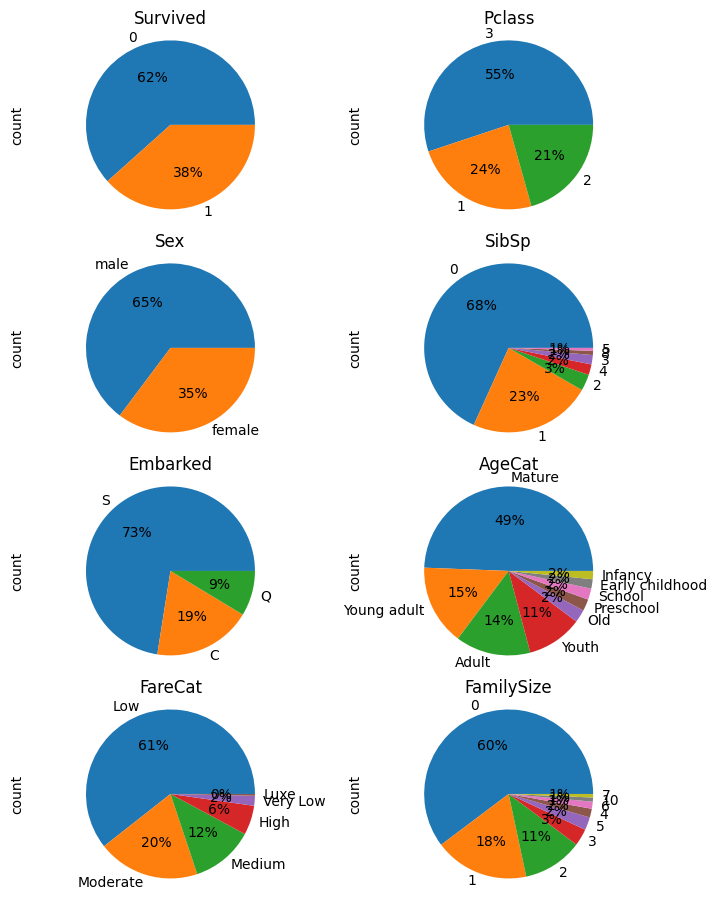

In [41]:
pie_list = ('Survived' , 'Pclass', 'Sex', 'SibSp')
fig = create_pie_chart_matrix(titanic_train, val_list_train, 2, 5, (8,14))

62% пассажиров утонули. Больше половины 

In [42]:
titanic_train.Cabin.describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [43]:
# удалим признаки Ticket и Cabin т.к. они не информативны
# remove features Ticket and Cabin because they are not informative
titanic_train = titanic_train.drop(['Ticket', 'Cabin'], axis=1)
titanic_test = titanic_test.drop(['Ticket', 'Cabin'], axis=1)


In [44]:
titanic_train['Title'] = titanic_train['Name'].str.extract(' ([A-Za-z]+)\.')
titanic_test['Title'] = titanic_test['Name'].str.extract(' ([A-Za-z]+)\.')
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeCat,FareCat,FamilySize,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Young adult,Low,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,71.2833,C,Mature,Medium,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Mature,Low,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mature,Medium,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mature,Low,0,Mr


In [45]:
titanic_train['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [46]:
titanic_train['Title'] = titanic_train['Title'].replace(
    ['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

titanic_train['Title'] = titanic_train['Title'].replace(
    ['Ms', 'Mlle'], 'Miss')

titanic_train['Title'] = titanic_train['Title'].replace(
    'Mme', 'Mrs')

# titanic_test['Title'] = titanic_test['Title'].replace(
#     ['Lady', 'Countess','Capt', 'Col',
#  	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [47]:
titanic_train['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

In [48]:
titanic_test['Title'].isna().sum()

0

In [49]:
titanic_test['Title'] = titanic_test['Title'].replace(
    ['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

titanic_test['Title'] = titanic_test['Title'].replace(
    ['Ms', 'Mlle'], 'Miss')

titanic_test['Title'] = titanic_test['Title'].replace(
    'Mme', 'Mrs')

In [50]:
titanic_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [51]:
def hist_categorical(data, col, rotate=45):
    sns.histplot(
        data,
        x=col,
        hue='Survived',
        multiple='fill'
    )

    plt.title(f'Количество выживших пассажиров по признаку "{col}"')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(rotation=rotate)
    plt.ylabel('Доля')

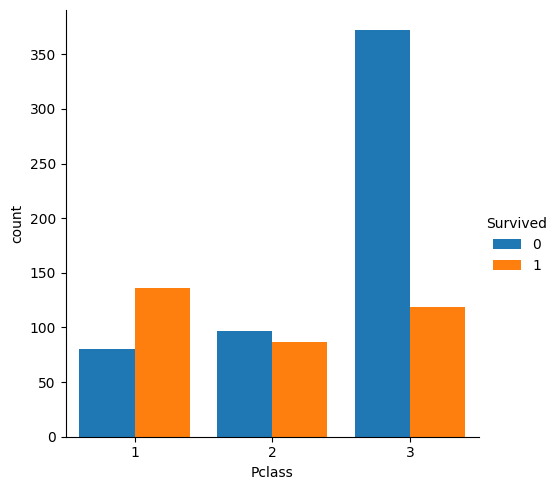

In [52]:
sns.catplot(data = titanic_train,hue = 'Survived', x = 'Pclass',
            kind='count', saturation=1.5);


Больше всего выживших (в абсолютном и процентном отношении) в 1-м классе. В основном погибли пассажиры 3-го класса.

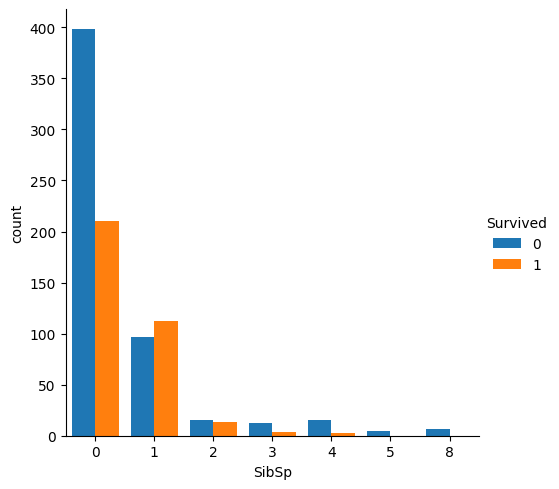

In [53]:
sns.catplot(data = titanic_train,hue = 'Survived', x = 'SibSp',
            kind='count', saturation=1.5);


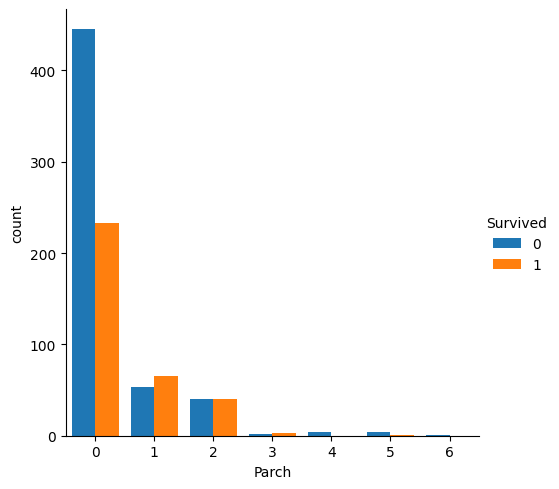

In [54]:
sns.catplot(data = titanic_train,hue = 'Survived', x = 'Parch',
            kind='count', saturation=1.5);


По графикам выживаемости для признаков SibSp и Parch видно что при наличии 1 родственника на борту вероятность выжить несколько выше чем в остальных случаях, но больше всего выживших среди тех кто плыл один. Самая высокая выживаемость (и смертность) в абсолютном выражении среди тех кто плыл в одиночку.

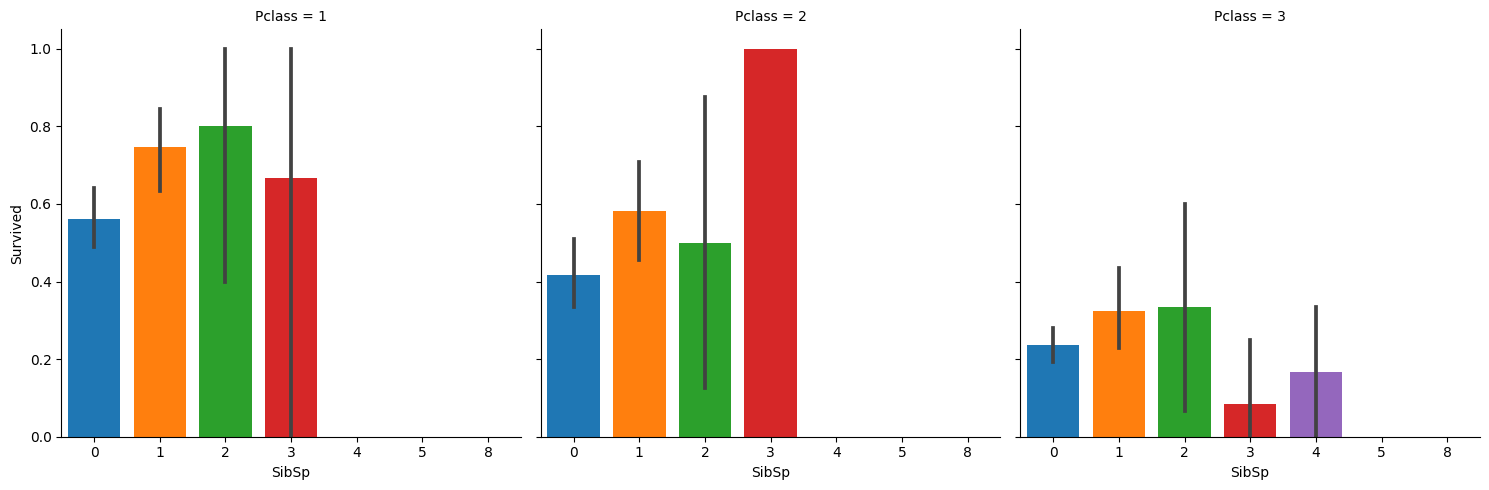

In [55]:
sns.catplot(data = titanic_train,y='Survived',x='SibSp',col='Pclass',
            kind='bar', saturation=1.5);


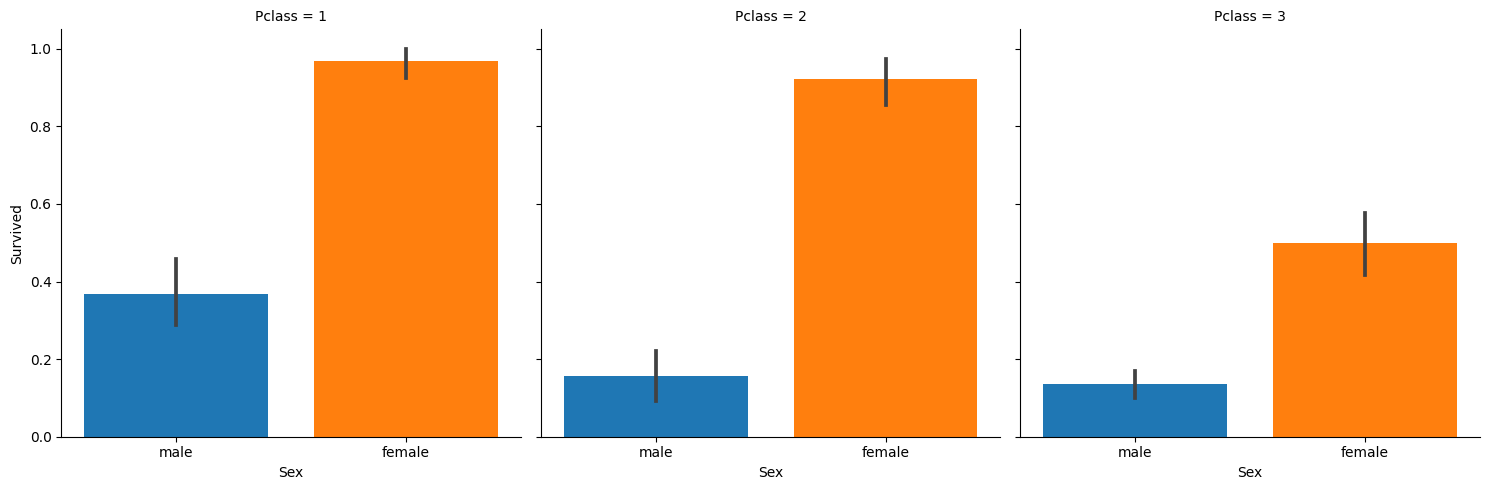

In [56]:
sns.catplot(data = titanic_train,y='Survived',x='Sex',col='Pclass',
            kind='bar', saturation=1.5);

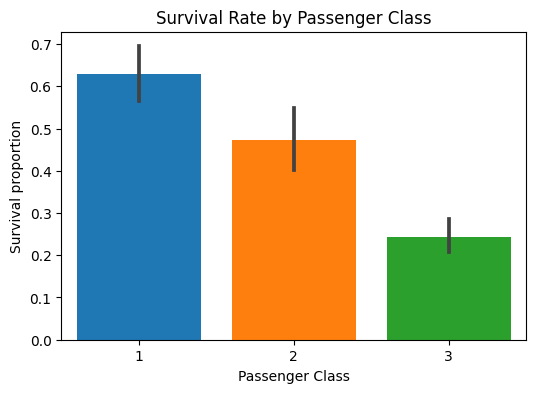

In [57]:
plt.figure(figsize=(6, 4))
sns.barplot(data = titanic_train,y='Survived',x='Pclass',
             saturation=1.5)
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival proportion')
plt.show()

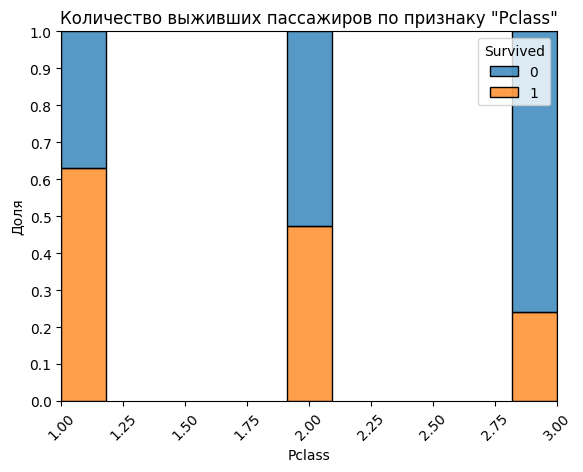

In [58]:
hist_categorical(titanic_train, 'Pclass')

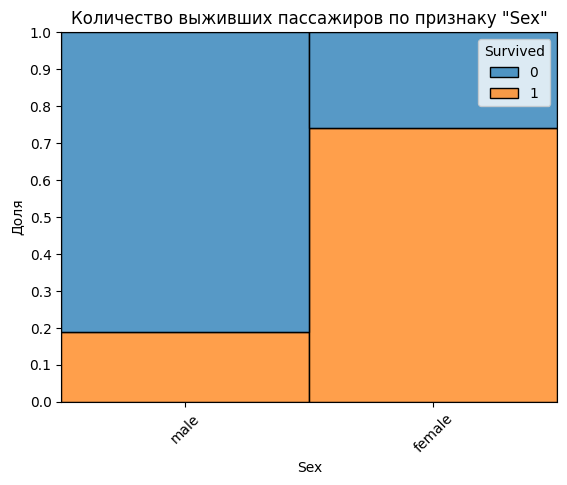

In [59]:
hist_categorical(titanic_train, 'Sex')

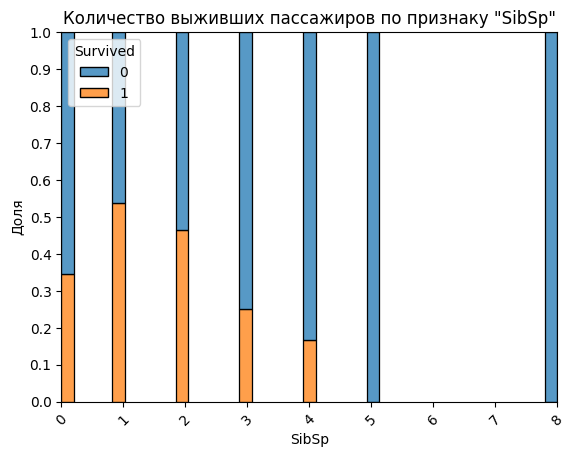

In [60]:
hist_categorical(titanic_train, 'SibSp')

### Корелляция\Corellation

In [61]:
titanic_train = titanic_train.drop(['PassengerId', 'Name'], axis=1)
titanic_test = titanic_test.drop(['PassengerId', 'Name'], axis=1)
# titanic_train = titanic_train.drop(['Name'], axis=1)
# titanic_test = titanic_test.drop(['Name'], axis=1)

In [62]:
interval_cols = ['Age','Fare']

In [63]:
import phik

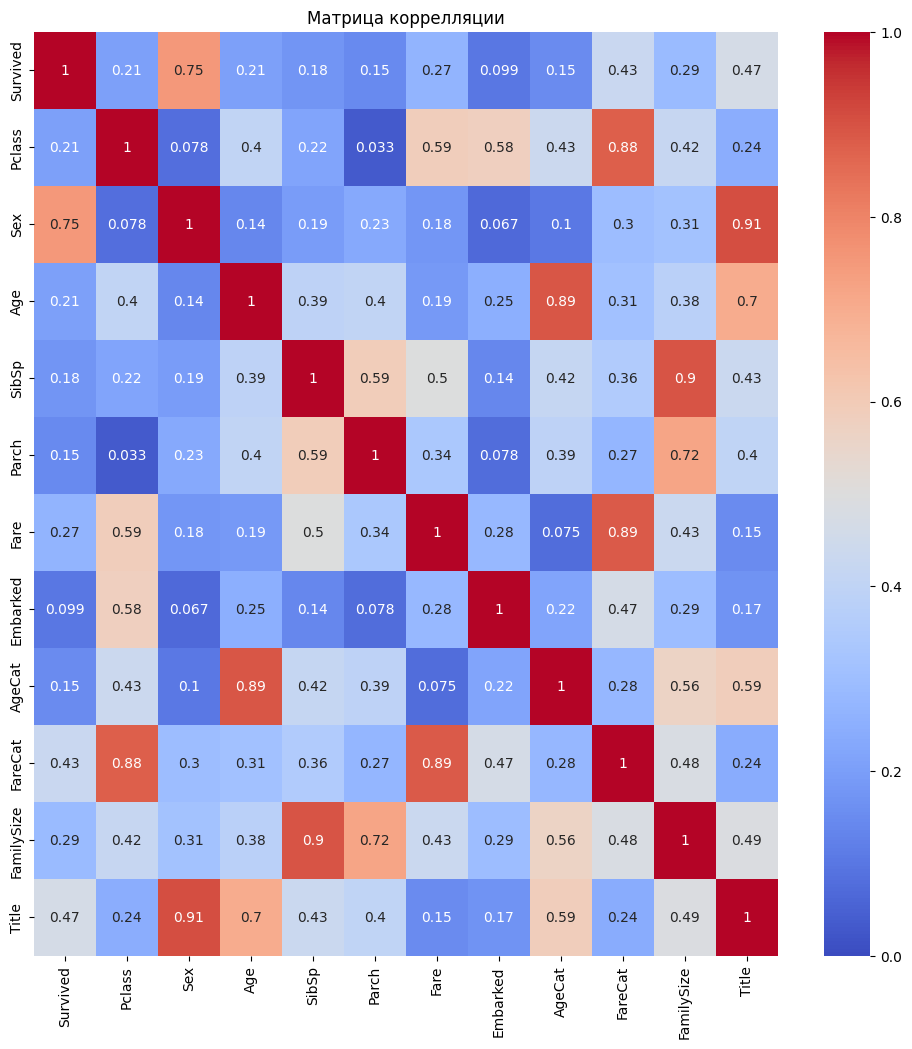

In [64]:
corr_matrix = titanic_train.phik_matrix(interval_cols=(interval_cols))
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Матрица коррелляции")
plt.show()

In [65]:
def corr_func(num, df, column):
    n = num
    col = column
    cond = df[col]>n
    col_list = cond[cond].index.tolist()
    col_list.remove(col)
    print (col_list)
    print (df[col][col_list])
    return [i for i in col_list]

In [66]:
#столбцы с заданной коррелляцией
# drop_list = corr_func (0.91, corr_matrix, 'Survived')
drop_list = ['Age', 'Fare', 'SibSp','Parch']
drop_list

['Age', 'Fare', 'SibSp', 'Parch']

In [67]:
titanic_train = titanic_train.drop(drop_list, axis=1)

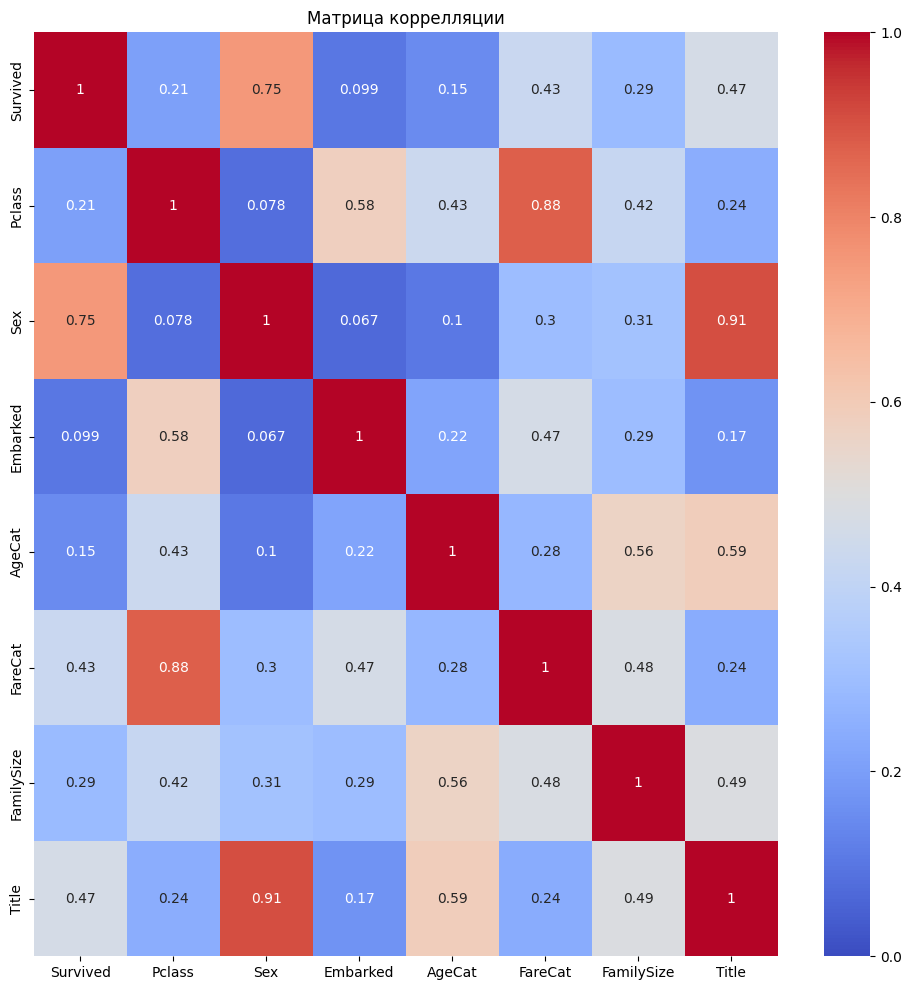

In [68]:
corr_matrix = titanic_train.phik_matrix(interval_cols=(interval_cols))
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Матрица коррелляции")
plt.show()

In [69]:
col_list = corr_func (0.01, corr_matrix, 'Survived')

['Pclass', 'Sex', 'Embarked', 'AgeCat', 'FareCat', 'FamilySize', 'Title']
Pclass        0.205464
Sex           0.750322
Embarked      0.099149
AgeCat        0.149528
FareCat       0.426110
FamilySize    0.287103
Title         0.465708
Name: Survived, dtype: float64


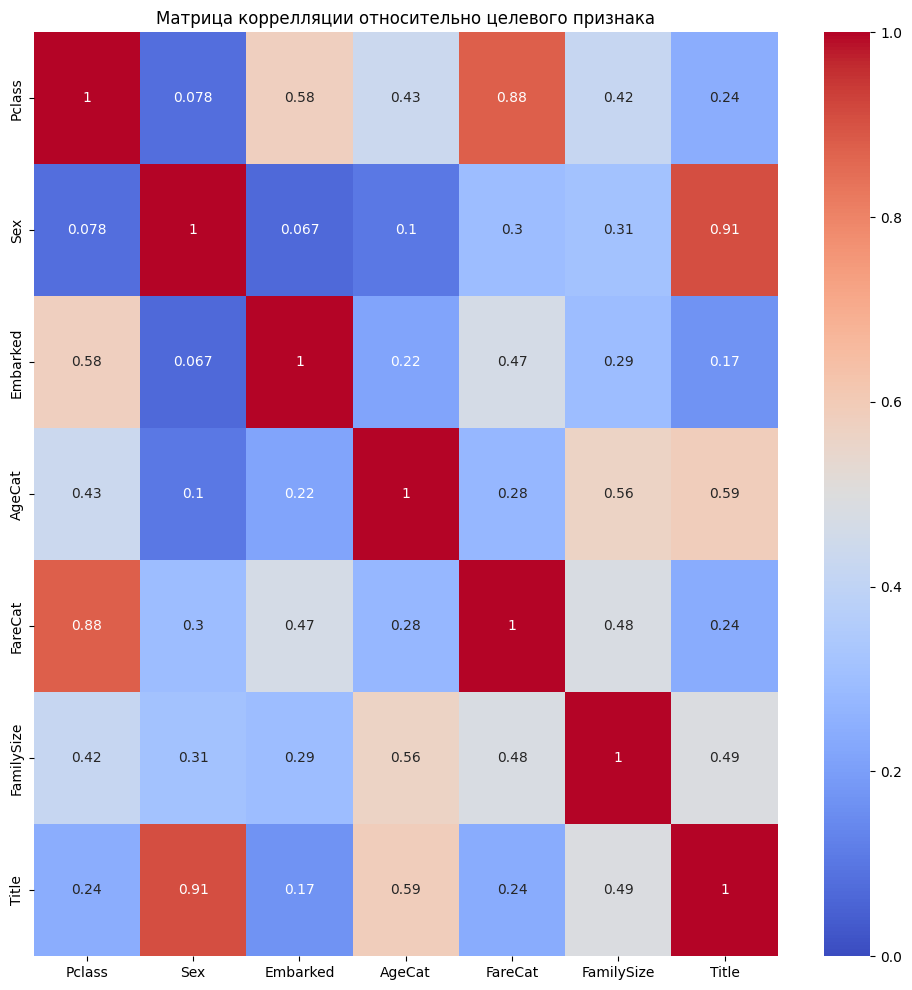

In [70]:
corr_matrix2 = titanic_train[(col_list)].phik_matrix(interval_cols=(interval_cols))
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Матрица коррелляции относительно целевого признака")
plt.show()

## Подготовка данных

In [71]:
def split_col(df):    
    return list(df.dtypes[df.dtypes=='object'].index), list(df.dtypes[df.dtypes!='object'].index)

In [72]:
cat_col, num_col = split_col(titanic_train)

In [73]:
num_col

['Survived', 'Pclass', 'FamilySize']

In [74]:
col_list

['Pclass', 'Sex', 'Embarked', 'AgeCat', 'FareCat', 'FamilySize', 'Title']

In [75]:
# выбор целевого признака
col = 'Survived'

# сохранение входных признаков в переменную X
X = titanic_train.drop(col, axis=1)


# сохранение целевого признака в переменную y
y = titanic_train[col]

In [76]:
col_list_for_test = X.columns.tolist()
X.head(5)

,Pclass,Sex,Embarked,AgeCat,FareCat,FamilySize,Title
0,3,male,S,Young adult,Low,1,Mr
1,1,female,C,Mature,Medium,1,Mrs
2,3,female,S,Mature,Low,0,Miss
3,1,female,S,Mature,Medium,1,Mrs
4,3,male,S,Mature,Low,0,Mr


In [77]:
cat_col, num_col = split_col(X)
print(f'cat_col: {cat_col}, num_col: {num_col}')

cat_col: ['Sex', 'Embarked', 'AgeCat', 'FareCat', 'Title'], num_col: ['Pclass', 'FamilySize']


In [78]:
features = X.copy()
target = y.copy()
# features_categorical = features[cat_col]

In [79]:
features_train, features_val, target_train, target_val = train_test_split(
    features,
    target,
    shuffle=False,
    test_size=TEST_SIZE,
    random_state = RANDOM_STATE)
    # stratify = y)

In [80]:
print('features_train.shape', features_train.shape)
print('features_val.shape', features_val.shape)
print('target_train.shape', target_train.shape)
print('target_val.shape', target_val.shape)

# проверка соответствия столбцов в выборках
features_train.columns == features_val.columns

features_train.shape (668, 7)
features_val.shape (223, 7)
target_train.shape (668,)
target_val.shape (223,)


array([ True,  True,  True,  True,  True,  True,  True])

In [81]:
lin_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),  # Нормализация числовых признаков
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_col)  # Кодирование категориальных признаков
    ]
)

wood_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),  # Нормализация числовых признаков
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', 
                               unknown_value=-1), cat_col)  # Кодирование категориальных признаков
    ]
)

# OrdinalEncoder(handle_unknown='use_encoded_value', 
#                                unknown_value=-1), cat_col) 

In [82]:
features_train

,Pclass,Sex,Embarked,AgeCat,FareCat,FamilySize,Title
0,3,male,S,Young adult,Low,1,Mr
1,1,female,C,Mature,Medium,1,Mrs
2,3,female,S,Mature,Low,0,Miss
3,1,female,S,Mature,Medium,1,Mrs
4,3,male,S,Mature,Low,0,Mr
...,...,...,...,...,...,...,...
663,3,male,S,Mature,Low,0,Mr
664,3,male,S,Young adult,Low,1,Mr
665,2,male,S,Mature,Medium,2,Mr
666,2,male,S,Young adult,Low,0,Mr


## Обучение моделей

In [83]:
results_df = pd.DataFrame(columns=['Model', 'Best metric', 'Best params'])

### Logistic Regression CV

In [84]:
# Создаем полный пайплайн
lr_pipeline = Pipeline(steps=[
    ('preprocessor', lin_preprocessor),
    ('classifier', LogisticRegressionCV(cv=5,
                                        random_state=RANDOM_STATE,
                                        refit=True,
                                        n_jobs=-1,
                                        Cs=[100, 10, 1, 0.1, 0.01, 0.001],
                                        scoring='roc_auc'))
])


lr_pipeline.fit(features_train, target_train)


best_C = lr_pipeline.named_steps['classifier'].C_[0]

print(f'Best C: {best_C}')


Best C: 1.0


In [85]:
LogReg_best_metric = round(lr_pipeline.named_steps['classifier'].scores_[1].max(), 3)
LogReg_best_params = lr_pipeline.named_steps['classifier'].C_[0]
LogReg_best_model = lr_pipeline.named_steps['classifier'].get_params(deep=True)

In [86]:
results_df.loc[0] = ['LogisticRegression', LogReg_best_metric, LogReg_best_params]
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
0,LogisticRegression,0.913,1.0


### DecisionTreeClassifier

In [87]:
DTC_param_grid  = [  
    # словарь для модели DecisionTreeClassifier()
    {
        'classifier__max_depth': range (2, 12),
        'classifier__max_features': range (2, 12)            
    }
]
# СоздаемСоздаем пайплайн
DTC_pipeline = Pipeline(steps=[
    ('preprocessor', wood_preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Используем RandomizedSearchCV для поиска лучших гиперпараметров
DTC_search_cv = RandomizedSearchCV(DTC_pipeline, 
                               param_distributions=DTC_param_grid, 
                               cv=5, 
                               random_state=RANDOM_STATE, 
                               refit=True, error_score="raise",
                               n_jobs=-1, 
                               scoring='roc_auc')


DTC_search_cv.fit(features_train, target_train)
DTC_best_metric = max(DTC_search_cv.cv_results_['mean_test_score'])
DTC_best_params = DTC_search_cv.best_params_
DTC_best_model = DTC_search_cv.best_estimator_

In [88]:
results_df.loc[1] = ['DecisionTreeClassifier', DTC_best_metric, DTC_best_params]
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
0,LogisticRegression,0.913000,1.0
1,DecisionTreeClassifier,0.843116,"{'classifier__max_features': 5, 'classifier__max_depth': 4}"


### RandomForestClassifier


In [89]:
RFC_param_grid  = [  
    # словарь для модели DecisionTreeClassifier()
    {
        'classifier__n_estimators' : [10, 20, 50, 100, 150]         
    }
]
# СоздаемСоздаем пайплайн
RFC_pipeline = Pipeline(steps=[
    ('preprocessor', wood_preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Используем RandomizedSearchCV для поиска лучших гиперпараметров
RFC_search_cv = RandomizedSearchCV(RFC_pipeline, 
                               param_distributions=RFC_param_grid, 
                               cv=5, 
                               random_state=RANDOM_STATE, 
                               refit=True, error_score="raise",
                               n_jobs=-1, 
                               scoring='roc_auc')


RFC_search_cv.fit(features_train, target_train)
RFC_best_metric = max(RFC_search_cv.cv_results_['mean_test_score'])
RFC_best_params = RFC_search_cv.best_params_
RFC_best_model = RFC_search_cv.best_estimator_

In [90]:
results_df.loc[2] = ['RandomForestClassifier', RFC_best_metric, RFC_best_params]
# ['Model', 'Best metric', 'Best params', 'Best estimator']
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
0,LogisticRegression,0.913000,1.0
1,DecisionTreeClassifier,0.843116,"{'classifier__max_features': 5, 'classifier__max_depth': 4}"
2,RandomForestClassifier,0.830483,{'classifier__n_estimators': 150}


### LightGBM

In [91]:
LGBM_param_grid  = [  
    # словарь для модели DecisionTreeClassifier()
    {
        'classifier__n_estimators' : [10, 20, 50, 100, 150], 
        'classifier__learning_rate': [0.01, 0.1, 1, 10],
        'classifier__max_depth': range(1, 11, 2)         
    }
]
# СоздаемСоздаем пайплайн
LGBM_pipeline = Pipeline(steps=[
    ('preprocessor', wood_preprocessor),
    ('classifier', LGBMClassifier(random_state=RANDOM_STATE))
])

# Используем RandomizedSearchCV для поиска лучших гиперпараметров
LGBM_search_cv = RandomizedSearchCV(LGBM_pipeline, 
                               param_distributions=LGBM_param_grid, 
                               cv=5, 
                               random_state=RANDOM_STATE, 
                               refit=True, error_score="raise",
                               n_jobs=-1, 
                               scoring='roc_auc')


LGBM_search_cv.fit(features_train, target_train)
LGBM_best_metric = max(LGBM_search_cv.cv_results_['mean_test_score'])
LGBM_best_params = LGBM_search_cv.best_params_
LGBM_best_model = LGBM_search_cv.best_estimator_

[LightGBM] [Info] Number of positive: 260, number of negative: 408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389222 -> initscore=-0.450586
[LightGBM] [Info] Start training from score -0.450586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [92]:
results_df.loc[3] = ['LightGBM', LGBM_best_metric, LGBM_best_params]
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
0,LogisticRegression,0.913000,1.0
3,LightGBM,0.850997,"{'classifier__n_estimators': 10, 'classifier__max_depth': 1, 'classifier__learning_rate': 1}"
1,DecisionTreeClassifier,0.843116,"{'classifier__max_features': 5, 'classifier__max_depth': 4}"
2,RandomForestClassifier,0.830483,{'classifier__n_estimators': 150}


In [93]:
catboost = CatBoostClassifier(#loss_function='Logloss',
                              cat_features=cat_col,
                              eval_metric='AUC:hints=skip_train~false',
                              random_state=RANDOM_STATE,
                              verbose=300)

catboost.fit(features_train,
             target_train,
             eval_set=(features_val, target_val),
             use_best_model=True)

# Получаем вероятности для ROC-AUC
y_pred_prob = catboost.predict(features_val)
catboost_best_metric = catboost.get_best_score()['validation']['AUC']
catboost_best_params = catboost.get_params()

Learning rate set to 0.028683
0:	learn: 0.8601857	test: 0.8953901	best: 0.8953901 (0)	total: 58.3ms	remaining: 58.3s
300:	learn: 0.9402196	test: 0.9048175	best: 0.9139855 (98)	total: 796ms	remaining: 1.85s
600:	learn: 0.9667374	test: 0.9004065	best: 0.9139855 (98)	total: 1.52s	remaining: 1.01s
900:	learn: 0.9794542	test: 0.9017039	best: 0.9139855 (98)	total: 2.27s	remaining: 249ms
999:	learn: 0.9821550	test: 0.8997146	best: 0.9139855 (98)	total: 2.51s	remaining: 0us

bestTest = 0.9139854696
bestIteration = 98

Shrink model to first 99 iterations.


In [94]:
print(catboost.get_best_score()['validation']['AUC'])

0.9139854696419305


In [95]:
results_df.loc[4] = ['catboost', catboost_best_metric, catboost_best_params]
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
4,catboost,0.913985,"{'verbose': 300, 'eval_metric': 'AUC:hints=skip_train~false', 'random_state': 25052015, 'cat_features': ['Sex', 'Embarked', 'AgeCat', 'FareCat', 'Title']}"
0,LogisticRegression,0.913000,1.0
3,LightGBM,0.850997,"{'classifier__n_estimators': 10, 'classifier__max_depth': 1, 'classifier__learning_rate': 1}"
1,DecisionTreeClassifier,0.843116,"{'classifier__max_features': 5, 'classifier__max_depth': 4}"
2,RandomForestClassifier,0.830483,{'classifier__n_estimators': 150}


# Prediction
Я буду использовать catboost, так как у модели лучшая метрика roc-auc
I will be use the catboost model, because it have best roc-auc metric

In [96]:
titanic_test
X_pred = titanic_test[col_list_for_test]
X_pred

,Pclass,Sex,Embarked,AgeCat,FareCat,FamilySize,Title
0,3,male,Q,Mature,Low,0,Mr
1,3,female,S,Adult,Low,1,Mrs
2,2,male,Q,Old,Low,0,Mr
3,3,male,S,Mature,Low,0,Mr
4,3,female,S,Young adult,Low,2,Mrs
...,...,...,...,...,...,...,...
413,3,male,S,Mature,Low,0,Mr
414,1,female,C,Mature,High,0,Rare
415,3,male,S,Mature,Low,0,Mr
416,3,male,S,Mature,Low,0,Mr


In [97]:
test_predictions = catboost.predict(X_pred)

In [98]:
submission = pd.DataFrame({
    'PassengerId': id_pred,
    'Survived': test_predictions
})
submission.to_csv('submission.csv', index=False)
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
